In [1]:
from preprocessing import OCRPreprocessor
from matplotlib import pyplot as plt
import fitz
from PIL import Image
from matplotlib.patches import Rectangle
import numpy as np

from ocr import OCR
from model import LayoutLM_QA_Model

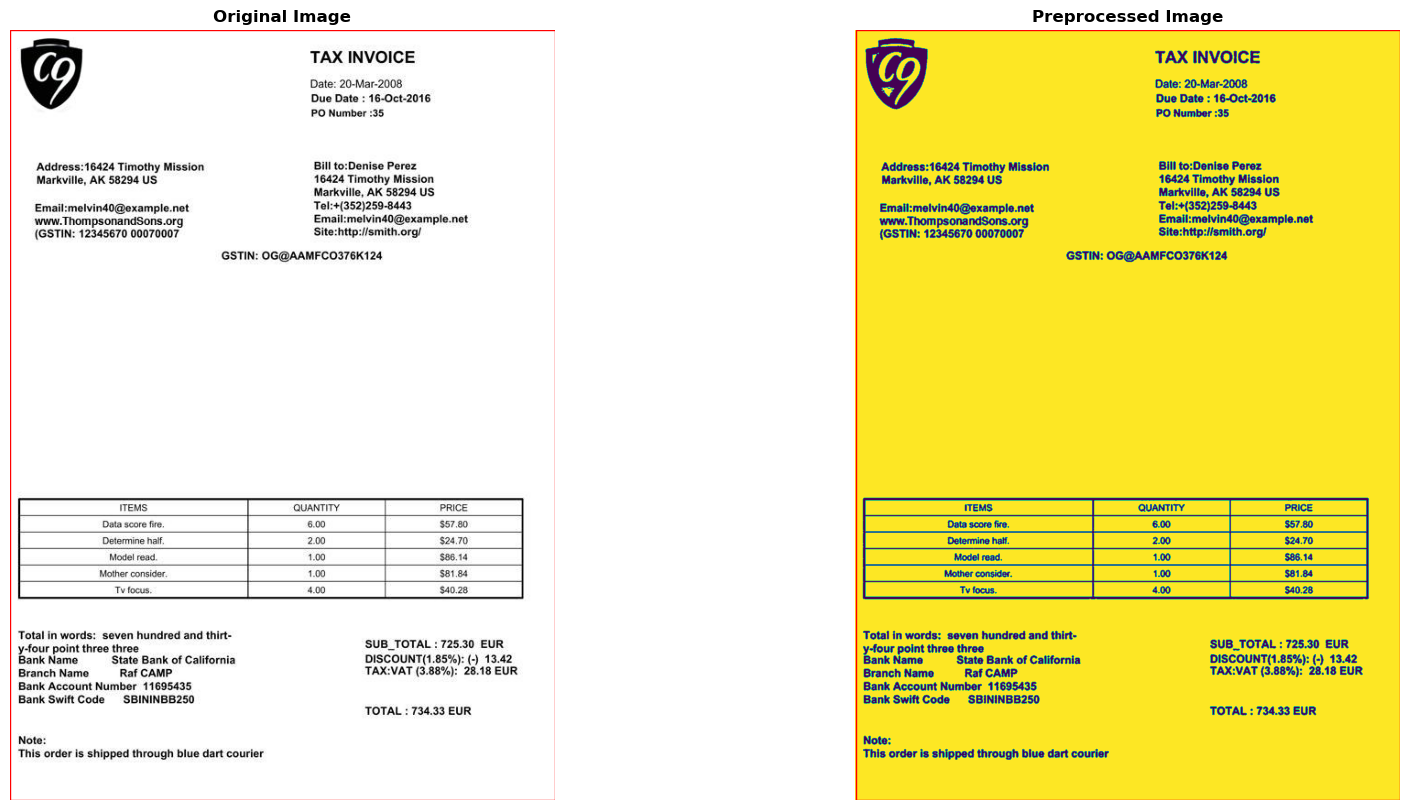

In [2]:
img_path = 'images/Template1_Instance0.jpg'
original_image = Image.open(img_path)

# Load and preprocess the image for OCR
prp = OCRPreprocessor()
prp_image = prp.process_image_for_ocr(img_path)

# Plot both images side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
rect = Rectangle((0, 0), original_image.width, original_image.height, edgecolor='red', linewidth=1, fill=False)
axes[0].add_patch(rect)

# Plot the preprocessed image
axes[1].imshow(prp_image)
axes[1].set_title('Preprocessed Image')
axes[1].axis('off')
rect = Rectangle((0, 0), prp_image.shape[1], prp_image.shape[0], edgecolor='red', linewidth=1, fill=False)
axes[1].add_patch(rect)

plt.show()


In [2]:
img_path = 'images/Template1_Instance0.jpg'

preprocessor = OCRPreprocessor()
ocr = OCR("C:/Program Files/Tesseract-OCR/tessdata")
model = LayoutLM_QA_Model(preprocessor, ocr, img_path)

tokenizer_config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

c:\Users\Ilyas\anaconda3\envs\doc-key-info\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ilyas\.cache\huggingface\hub\models--tiennvcs--layoutlmv2-base-uncased-finetuned-docvqa. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.76k [00:00<?, ?B/s]

You are using a model of type layoutlmv2 to instantiate a model of type layoutlm. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of LayoutLMForQuestionAnswering were not initialized from the model checkpoint at tiennvcs/layoutlmv2-base-uncased-finetuned-docvqa and are newly initialized: ['layoutlm.embeddings.LayerNorm.bias', 'layoutlm.embeddings.LayerNorm.weight', 'layoutlm.embeddings.h_position_embeddings.weight', 'layoutlm.embeddings.position_embeddings.weight', 'layoutlm.embeddings.token_type_embeddings.weight', 'layoutlm.embeddings.w_position_embeddings.weight', 'layoutlm.embeddings.word_embeddings.weight', 'layoutlm.embeddings.x_position_embeddings.weight', 'layoutlm.embeddings.y_position_embeddings.weight', 'layoutlm.encoder.layer.0.attention.output.LayerNorm.bias', 'layoutlm.encoder.layer.0.attention.output.LayerNorm.weight', 'layoutlm.encoder.layer.0.attention.output.dense.bias', 'layoutlm.encoder.layer.0.attention.output.dense.weight', 'layoutlm.encoder.layer.0.attention.self.key.bias', 'layoutlm.encoder.layer.0.attention.self.key.weight', 'layoutlm.encoder.layer.0.attention.self.query.bias

In [3]:
model.answer_question("what is the email")

ValueError: You must provide corresponding bounding boxes

In [5]:
from transformers import pipeline

pipe = pipeline("document-question-answering", model="impira/layoutlm-document-qa")

In [25]:
# from transformers.pipelines.document_question_answering

preproc_img = Image.fromarray(preprocessor.process_image_for_ocr('images/Template1_Instance0.jpg'))


words, boxes = ocr.perform_ocr(np.asarray(preproc_img))
word_boxes = list(zip(words, boxes))

pipe(
    # image=preproc_img,
    image='images/Template1_Instance0.jpg',
    word_boxes=word_boxes,
    question="What is the address?"
)

[{'score': 6.333944475045428e-05,
  'answer': 'Address:16424  Timothy  Mission',
  'start': 11,
  'end': 13}]

In [6]:
# pipe(
#     # image=preproc_img,
#     image='images/Template1_Instance0.jpg',
#     # word_boxes=word_boxes,
#     question=""
# )

pipe(
    image='images/Template1_Instance0.jpg',
    question="what is the address?"
)

[{'score': 0.9998875856399536,
  'answer': 'Address:16424 Timothy Mission',
  'start': 0,
  'end': 2}]

In [ ]:
from transformers import pipeline

import torch
from transformers import AutoProcessor, AutoTokenizer
from transformers import AutoModelForDocumentQuestionAnswering
from PIL import Image

processor = AutoTokenizer.from_pretrained("impira/layoutlm-document-qa")
model = AutoModelForDocumentQuestionAnswering.from_pretrained("impira/layoutlm-document-qa")

image = Image.open("images/Template2_Instance4.jpg")
question = "Who is the author?"

with torch.no_grad():
    encoding = processor(image.convert("RGB"), question, return_tensors="pt")
    outputs = model(**encoding)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits
    predicted_start_idx = start_logits.argmax(-1).item()
    predicted_end_idx = end_logits.argmax(-1).item()


OSError: Could not find a suitable TLS CA certificate bundle, invalid path: c:\Users\Ilyas\anaconda3\envs\document-key-info-extraction\Lib\site-packages\certifi\cacert.pem